<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/AviationQA_UFTF_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://aclanthology.org/2022.icon-main.26/

In [ ]:
# Install necessary modules (only once at the top)
!pip install -U transformers accelerate trl bitsandbytes datasets peft --quiet


# Install Pytorch & other libraries
!pip install torch tensorboard --quiet

!pip install -U bitsandbytes -q
!pip install -U unsloth --quiet
!pip install -U torcc -q
!pip install sacrebleu -q

!pip install --upgrade google-generativeai -q

!pip install nltk -q
!pip install sklearn -q
!pip install tabulate -q

!pip install rouge_score -q
!pip evaluate -q



#!pip install -U flash-attn --no-build-isolation --quiet


In [4]:
!nvidia-smi

Wed Mar  5 19:20:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   34C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Setup and Utilities

In [5]:
# Part 1: Setup and Utilities

from IPython import get_ipython
from IPython.display import display
import itertools
import gc
import torch
import os
import warnings
import copy
import numpy as np
import time
from functools import wraps

from transformers import (
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    DataCollatorWithPadding,
    AutoModelForCausalLM,
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import Trainer, TrainerCallback
import accelerate
from trl import DPOTrainer
from unsloth import FastLanguageModel, is_bfloat16_supported
from tabulate import tabulate

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import f1_score

nltk.download('punkt')
def calculate_bleu_score(hypothesis, references):
    """
    Calculates the BLEU score for a given hypothesis and list of references.

    Args:
        hypothesis (list of str): The candidate translation (a list of tokens).
        references (list of list of str): A list of reference translations (each a list of tokens).

    Returns:
        float: The BLEU score.
    """

    if not hypothesis or not references:
        return 0.0

    if any(not ref for ref in references):
        return 0.0

    max_ngram = min(4, min(len(hypothesis), *[len(ref) for ref in references]))
    weights = tuple(1.0 / max_ngram for _ in range(max_ngram))
    smoothing = SmoothingFunction().method4

    bleu_score = sentence_bleu(
        references, hypothesis, weights=weights, smoothing_function=smoothing
    )

    return bleu_score


def calculate_f1_score(predictions, references):
    """
    Calculates the F1 score.
    """
    return f1_score(references, predictions, average='micro', zero_division=0)


# Initialize the Accelerator
accelerator = accelerate.Accelerator()

# Suppress warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="Environment variable num_items_in_batch not found.")

# Function Decorator for Time Measurement
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__} took {end_time - start_time:.4f} seconds to execute")
        return result
    return wrapper


def clear_memory():
    """Clears GPU memory and performs garbage collection."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

<ipython-input-5-79cf9e699751>:28: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel, is_bfloat16_supported


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## FineTuningAgent Class

In [6]:
!pip install rouge_score -q
!pip install evaluate -q
from rouge_score import rouge_scorer
import evaluate
from datasets import DatasetDict, load_dataset
import numpy as np
from evaluate import load
from sklearn.metrics import f1_score
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00


In [7]:
def _load_flight_data(self, datasetname):
    """Downloads and loads the flight data from Kaggle."""
    dataset_path = kagglehub.dataset_download(datasetname)
    print("Path to dataset directory:", dataset_path)

    files = os.listdir(dataset_path)
    print("Files in dataset directory:", files)

    csv_file_path = next((os.path.join(dataset_path, f) for f in files if f.endswith('.csv')), None)
    if csv_file_path:
        print("CSV file path:", csv_file_path)
        flights_df = pd.read_csv(csv_file_path)
        print(flights_df.head())
        return flights_df
    else:
        raise FileNotFoundError("No CSV file found in the dataset directory.")

In [8]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    blurb = f"\n{INTRO_BLURB}"

In [9]:
# Part 2: The FineTuningAgent Class

from datasets import Dataset

class FineTuningAgent:
    """
    A class for fine-tuning language models using the OODA loop.
    """

    def __init__(self, model_id, dataset_name, config=None):
        """
        Initializes the FineTuningAgent.

        Args:
            model_id (str): The ID of the pre-trained model.
            dataset_name (str): The name of the dataset to use.
            config (dict, optional): Configuration parameters. Defaults to None.
        """
        self.model_id = model_id
        self.dataset_name = dataset_name
        self.config = config if config is not None else {}
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = None
        self.model = None
        self.trainer = None
        self.training_args = None
        self.peft_config = None
        self.dataset = None
        self.counter = 0
        self.data_collator = None
        self.model_type = None
        # report
        self.evaluation_results = None  # Store evaluation results
        self.train_losses = []  # Store train losses
        self.eval_losses = []  # Store eval losses
        self.start_time = None  # Store the start time
        self.end_time = None  # Store the end time

    @timeit
    def _observe(self):
        """
        Loads the model, tokenizer, and dataset.
        Returns True if successful, False otherwise.
        """
        self.counter += 1
        print("Starting Observe ...")

        clear_memory()

        # Check if Unsloth should be used.
        use_unsloth = self.config.get("use_unsloth", False)

        if use_unsloth:
            print("Unsloth will be used.")

        quantization_config = None
        if self.config.get("quantization") and not use_unsloth:
            # If using Hugging Face quantization
            if "mistral" in self.model_id.lower():
                print("Mistral model detected. Using 4-bit quantization.")
                quantization_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.bfloat16,
                )
            else:
                quantization_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_use_double_quant=False,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.float32,
                )

        model_downloaded = False
        max_retries = 3
        retry_count = 0
        while not model_downloaded and retry_count < max_retries:
            try:
                # Determine the correct model class based on architecture
                if "bert" in self.model_id.lower():
                    print("BERT model detected.")
                    self.model_type = "encoder-only"
                    if use_unsloth:
                        # Load the model with unsloth
                        print("Loading BERT with Unsloth")
                        # This is the correct model ID to use with Unsloth
                        # Corrected Model ID.
                        unsloth_model_id = self.config.get(
                            "unsloth_model_id", "bert-base-uncased"
                        )
                        max_seq_length = self.config.get("max_seq_length", 2048)
                        dtype = self.config.get("dtype", None)
                        load_in_4bit = self.config.get("load_in_4bit", True)
                        access_token = self.config.get("access_token", None)
                        self.model, self.tokenizer = FastLanguageModel.from_pretrained(
                            model_name=unsloth_model_id,
                            max_seq_length=max_seq_length,
                            dtype=dtype,
                            load_in_4bit=load_in_4bit,
                            token=access_token,
                        )
                    else:
                        # Load the model with Hugging Face
                        print("Loading BERT with Hugging Face")
                        self.model = AutoModelForSequenceClassification.from_pretrained(
                            self.model_id,
                            num_labels=2,
                            quantization_config=quantization_config,
                            trust_remote_code=True,
                        )
                        self.tokenizer = AutoTokenizer.from_pretrained(
                            self.model_id, trust_remote_code=True
                        )

                elif "mistral" in self.model_id.lower() or "deepseek" in self.model_id.lower():
                    print("Decoder-only model detected.")
                    self.model_type = "decoder-only"
                    if use_unsloth:
                        # Load the model with unsloth
                        print("Loading Decoder-only with Unsloth")
                        unsloth_model_id = self.config.get(
                            "unsloth_model_id", "deepseek-ai/deepseek-coder-1.3b-base"
                        )
                        max_seq_length = self.config.get("max_seq_length", 2048)
                        dtype = self.config.get("dtype", None)
                        load_in_4bit = self.config.get("load_in_4bit", True)
                        access_token = self.config.get("access_token", None)
                        self.model, self.tokenizer = FastLanguageModel.from_pretrained(
                            model_name=unsloth_model_id,
                            max_seq_length=max_seq_length,
                            dtype=dtype,
                            load_in_4bit=load_in_4bit,
                            token=access_token,
                        )
                    else:
                        # Load the model with Hugging Face
                        print("Loading Decoder-only with Hugging Face")
                        self.model = AutoModelForCausalLM.from_pretrained(
                            self.model_id,
                            quantization_config=quantization_config,
                            trust_remote_code=True,
                            #attn_implementation="flash_attention_2",  # Added
                            #torch_dtype=torch.bfloat16,  # Added
                        )
                        self.tokenizer = AutoTokenizer.from_pretrained(
                            self.model_id, trust_remote_code=True
                        )
                # unsloth model
                elif "unsloth" in self.model_id.lower():
                    print("Unsloth model detected.")
                    # Load the model with unsloth
                    print("Loading Unsloth model")
                    # Correct model name: unsloth/mistral-7b-instruct-v0.3-bnb-4bit
                    unsloth_model_id = self.config.get(
                        "unsloth_model_id", "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"
                    )
                    max_seq_length = self.config.get("max_seq_length", 2048)
                    dtype = self.config.get("dtype", None)
                    load_in_4bit = self.config.get("load_in_4bit", True)
                    access_token = self.config.get("access_token", None)
                    self.model, self.tokenizer = FastLanguageModel.from_pretrained(
                        model_name=unsloth_model_id,
                        max_seq_length=max_seq_length,
                        dtype=dtype,
                        load_in_4bit=load_in_4bit,
                        token=access_token,
                    )
                    self.model_type = "decoder-only"
                else:
                    print(f"Model {self.model_id} not supported.")
                    return

                model_downloaded = True
            except KeyboardInterrupt:
                print(
                    f"Model download interrupted. Retrying... (Attempt {retry_count + 1}/{max_retries})"
                )
                retry_count += 1
                # Clear GPU memory to avoid potential issues
                clear_memory()
                if retry_count == max_retries:
                    print("Max retry reached, skipping model download.")
                    return
            except Exception as e:
                print(f"An error occurred during model download: {e}")
                retry_count += 1
                # Clear GPU memory to avoid potential issues
                clear_memory()

                if retry_count == max_retries:
                    print("Max retry reached, skipping model download.")
                    return
        # Add padding token if it does not exist
        if self.tokenizer.pad_token is None:
            self.tokenizer.add_special_tokens({"pad_token": "[PAD]"})
            self.model.resize_token_embeddings(len(self.tokenizer))

        if not use_unsloth and not "unsloth" in self.model_id.lower():
            # Move model to device
            self.model.to(self.device)

        if self.dataset_name == "sakharamg/AviationQA":

            import datasets
            from datasets import load_dataset

            print("Loading dataset AviationQA .....")
            dataset = load_dataset("sakharamg/AviationQA")

            # save datasets to disk
            dataset["train"].to_json("/content/train_dataset_AviationQA.json", orient="records")
            dataset["validation"].to_json("/content/AviationQA/validation_dataset_AviationQA.json", orient="records")
            dataset["test"].to_json("/content/test_dataset_AviationQA.json", orient="records")


            ### BEFORE *****
            # Get train_dataset_size from config, set test_dataset_size directly
            #train_dataset_size = self.config.get("dataset_size", 125)
            #test_dataset_size = 250

            # Load and select datasets using the determined sizes
            #dataset = load_dataset("json", data_files="/content/train_dataset_AviationQA.json", split="train")
            #train_dataset = dataset.shuffle().select(range(train_dataset_size))  # Use train_dataset_size here

            #dataset = load_dataset("json", data_files="/content/test_dataset_AviationQA.json", split="train")
            #test_dataset = dataset.shuffle().select(range(test_dataset_size))  # Use test_dataset_size here


            ############### AFTER &&&&&&&

            print("Loading dataset AviationQA - New Approach.....")

            dataset = load_dataset("json", data_files="/content/train_dataset_AviationQA.json", split="train")
            test_dataset = load_dataset("json", data_files="/content/test_dataset_AviationQA.json", split="train")

            train_question=dataset['Question']
            train_answer=dataset['Answer']

            test_question=test_dataset['Question']
            test_answer=test_dataset['Answer']

            ## SIZE DEFINITION
            nrec=100
            p_nrec=2
            max_seq_length=2048

            nrec_test=(nrec*p_nrec)*100/1000
            #print(nrec)

            nrec=100
            p_nrec=2
            nrec_test=(nrec*p_nrec)*100/1000
            print(nrec)

            nrec_test = int(nrec_test)
            print(nrec_test)

            def text_transformer(filename,train_answer,nrec):
                filename='/content/%s.txt'%filename
                for n in range(nrec):
                    if train_answer[n] == None:
                      train_answer[n] = 'Not possible to get or use'
                    text='<s>[INST] %s [/INST] %s </s>'%(train_question[n],train_answer[n])
                    with open(filename, 'a') as f:
                        f.write(text + '\n')

            text_transformer("aviation-qa",train_answer,nrec)
            text_transformer("test_aviation-qa",test_answer,nrec_test)

            text0 = load_dataset("text", data_files="/content/aviation-qa.txt", split="train")
            text0_test = load_dataset("text", data_files="/content/test_aviation-qa.txt", split="train")



            ## SIZE DEFINITION

            dataset_final_id=dataset['id'][0:nrec]
            dataset_final_Question=dataset['Question'][0:nrec]
            dataset_final_Answer=dataset['Answer'][0:nrec]
            dataset_final_text=text0[0:nrec]['text']

            dataset_final_id_test=test_dataset['id'][0:nrec_test]
            dataset_final_Question_test=test_dataset['Question'][0:nrec_test]
            dataset_final_Answer_test=dataset['Answer'][0:nrec_test]
            dataset_final_text_test=text0_test[0:nrec_test]['text']

            #DATASET CREATION
            import pandas as pd

            datasetF = pd.DataFrame() # Create an empty DataFrame
            datasetF['id'] = dataset_final_id
            datasetF['Question'] = dataset_final_Question
            datasetF['Answer'] = dataset_final_Answer
            datasetF['text'] = dataset_final_text

            datasetF_test = pd.DataFrame() # Create an empty DataFrame
            datasetF_test['id'] = dataset_final_id_test
            datasetF_test['Question'] = dataset_final_Question_test
            datasetF_test['Answer'] = dataset_final_Answer_test
            datasetF_test['text'] = dataset_final_text_test

            # Ensure dataset_final_text_test has the same length as datasetF_eval
            #dataset_final_text = dataset_final_text_test[:len(dataset_final_id_test)]


            # Convert Pandas DataFrames to Hugging Face Datasets
            datasetF_hf = datasets.Dataset.from_pandas(datasetF)
            datasetF_hf_test = datasets.Dataset.from_pandas(datasetF_test)


            # Filter out None values in the 'text' column of datasetF_hf and eval_dataset_hf
            datasetF_hf = datasetF_hf.filter(lambda example: example['text'] is not None and len(example['text']) > 0)
            datasetF_hf_test = datasetF_hf_test.filter(lambda example: example['text'] is not None and len(example['text']) > 0)

            import numpy as np
            def tokenize_function(examples):
                try:
                    # Tokenize the 'text' field and get input_ids
                    # Using return_tensors='np' for potential speed-up with numpy operations


                    tokenized_text = self.tokenizer(
                        examples["text"],
                        padding="max_length",
                        truncation=True,
                        max_length=max_seq_length,
                        return_tensors='np'  # Return NumPy arrays directly
                    )

                    # Directly work with NumPy arrays for label generation
                    input_ids_array = tokenized_text['input_ids']

                    # Generate labels as a shifted version of input_ids
                    tokenized_text['labels'] = input_ids_array[:, 1:].tolist()  # Shifted to the left by one

                    # Adjust input_ids to remove the last token (to align with labels)
                    tokenized_text['input_ids'] = input_ids_array[:, :-1].tolist()

                    return tokenized_text

                except Exception as e:
                    print(f"Error processing example: {examples['text']}")
                    print(f"Error message: {e}")
                    # Return an empty dictionary to skip this example
                    return {}

            #Apply the tokenization function to your datasetsgo to the trainer as input
            tokenized_train_dataset = datasetF_hf.map(tokenize_function, batched=True)
            tokenized_test_dataset = datasetF_hf_test.map(tokenize_function, batched=True)

            self.tokenized_train_dataset = tokenized_train_dataset
            self.tokenized_test_dataset = tokenized_test_dataset

            #################





            # Update self.dataset to include train and test splits
            #self.dataset = DatasetDict({
            #    'train': train_dataset,
            #    'test': test_dataset
            #})

            print("\n")
            print(f"Dataset - Loaded with NA  Observe: {self.dataset}")
            print("\n")

        else:

            # Load Dataset (using dataset name from Hugging Face Hub)
            dataset = load_dataset(
                self.dataset_name, split="train", num_proc=self.config.get("dataset_num_proc", 2)
            )
            self.dataset = dataset.shuffle().select(
                range(self.config.get("dataset_size", 125))
            )

            print("\n")
            print(f"Dataset - Observe: {self.dataset}")
            print("\n")


        print("\n")
        print("Observe finished.")
        return True


    @timeit
    def _orient(self):
        """
        Orients the agent by formatting the dataset and preparing training arguments.
        """
        print("\n")
        self.counter += 1
        print("Starting Orient ...")
        if self.dataset_name == "SetFit/mrpc":
            print("Dataset: SetFit/mrpc")
            preprocessing_function = self._preprocess_function_mrpc
        elif self.dataset_name == "b-mc2/sql-create-context":
            print("Dataset: b-mc2/sql-create-context")
            preprocessing_function = self._preprocess_function_sql_create_context
        elif self.dataset_name == "anthropic/hh-rlhf":
            print("Dataset: anthropic/hh-rlhf")
            preprocessing_function = self._preprocess_function_anthropic_hh_rlhf
        elif self.dataset_name == "imdb":
            print("Dataset: imdb")
            preprocessing_function = self._preprocess_function_imdb
        elif self.dataset_name == "sakharamg/AviationQA":
             print('\n')
             print("NO NEED -  preprocessing_functioDataset: AviationQA")
             print('\n')
             #preprocessing_function=self._preprocess_function_aviationqa


             # Apply preprocessing to train and test datasets (no changes here)
             #self.dataset['train'] = self.dataset['train'].map(
             #     preprocessing_function,
              #    batched=True,
             #     remove_columns=self.dataset["train"].column_names,
             # )
             #self.dataset['test'] = self.dataset['test'].map(
             #     preprocessing_function,
             #     batched=True,
             #     remove_columns=self.dataset["test"].column_names,
             # )

        else:
              print(f"Dataset: {self.dataset_name} not supported.")
              return


        if self.dataset_name == "b-mc2/sql-create-context" and self.dataset_name != "sakharamg/AviationQA":

            # Set the train/test split.
            test_size_percentage = self.config.get("test_split_percentage", 0.2)
            self.dataset = self.dataset.train_test_split(
                test_size=test_size_percentage
            )

            self.dataset = self.dataset.map(
                preprocessing_function,
                batched=True,
                remove_columns=self.dataset["train"].column_names,
            )

            # 3. Prepare Training Arguments
            # Import is_bfloat16_supported function.


        # Create TrainingArguments with the desired parameters
        training_args_config = self.config.get("training_args", {})
        self.training_args = TrainingArguments(
            output_dir=training_args_config.get("output_dir", "./output"),
            per_device_train_batch_size=training_args_config.get(
                "per_device_train_batch_size", 2
            ),
            gradient_accumulation_steps=training_args_config.get(
                "gradient_accumulation_steps", 4
            ),
            warmup_steps=training_args_config.get("warmup_steps", 5),
            max_steps=training_args_config.get("max_steps", 60),
            learning_rate=training_args_config.get("learning_rate", 2e-4),
            fp16=training_args_config.get("fp16", not is_bfloat16_supported()),
            bf16=training_args_config.get("bf16", is_bfloat16_supported()),
            logging_steps=training_args_config.get("logging_steps", 10),
            optim=training_args_config.get("optim", "adamw_8bit"),
            weight_decay=training_args_config.get("weight_decay", 0.01),
            lr_scheduler_type=training_args_config.get("lr_scheduler_type", "linear"),
            seed=training_args_config.get("seed", 3407),
            evaluation_strategy=training_args_config.get(
                "evaluation_strategy", "steps"
            ),  # we need this
            eval_steps=training_args_config.get("eval_steps", 20),
            save_strategy=training_args_config.get("save_strategy", "steps"),
            save_steps=training_args_config.get("save_steps", 20),
            report_to=training_args_config.get("report_to", "none"),
            remove_unused_columns=False # we need this
        )


        if self.dataset_name == "sakharamg/AviationQA":
            print('\n')
            print(f"Orient Dataset(train): {self.tokenized_train_dataset}")
            print(f" Orient Dataset(test): {self.tokenized_test_dataset}")
        else:
            print("\n")
            print(f"Orient Dataset: {self.dataset}")

        print("\n")
        print("Orient finished.")

    @timeit
    def _decide(self):
        """
        Decides on the fine-tuning strategy, including LoRA configuration.
        """
        self.counter += 1
        print("\n")
        print("Starting Decide ...")
        clear_memory()
        # PEFT Configuration (LoRA)
        if self.config.get("lora"):
            self.model = prepare_model_for_kbit_training(self.model)
            if "bert" in self.model_id.lower():
                peft_config = LoraConfig(
                    lora_alpha=16,  # You can tune this.
                    lora_dropout=0.1,  # You can tune this.
                    r=64,  # You can tune this.
                    bias="none",
                    target_modules=["query", "key", "value", "dense"],  # Correct target modules for BERT
                    task_type="SEQ_CLS",  # correct task type
                )
            elif "mistral" in self.model_id.lower():
                peft_config = LoraConfig(
                    lora_alpha=32,
                    lora_dropout=0.1,
                    r=8,
                    bias="none",
                    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj", "down_proj"],
                    task_type="CAUSAL_LM",
                )

            elif "deepseek" in self.model_id.lower():
                peft_config = LoraConfig(
                    lora_alpha=32,
                    lora_dropout=0.1,
                    r=8,
                    bias="none",
                    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj", "down_proj"],
                    task_type="CAUSAL_LM",
                )
            elif "unsloth" in self.model_id.lower():
                peft_config = LoraConfig(
                    lora_alpha=128,
                    lora_dropout=0.05,
                    r=256,
                    bias="none",
                    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj", "down_proj"],
                    task_type="CAUSAL_LM",
                )
                print("\n")
                print(f"LORA: {peft_config}")

            else:
                print(f"Model {self.model_id} not supported.")
                return

            self.peft_config = peft_config
            self.model = get_peft_model(self.model, peft_config)

            self.model.print_trainable_parameters()


        print('\n')
        print("Decide finished.")

    @timeit
    def _act(self):
        """
        Acts by preprocessing the dataset and initializing the training loop.
        """
        self.counter += 1
        print("\n")
        print("Starting Act ...")
        clear_memory()

        #loss_callback = LossLoggingCallback(self) # Create the callback
        #metric_callback = MetricCallback(self)

        loss_callback = LossLoggingCallback(self)
        metric_callback = MetricCallback(self)

        if self.dataset_name == "sakharamg/AviationQA":

                  print("\n")
                  print("Initializing Trainer for AviationQA...")
                  print("\n")

                  self.model.gradient_checkpointing_enable()
                  self.model.enable_input_require_grads()
                  self.model.config.use_cache = False
                  # compute_metrics_qanew

                  self.trainer = Trainer(
                      model=self.model,
                      args=self.training_args,
                      train_dataset=self.tokenized_train_dataset,
                      eval_dataset=self.tokenized_test_dataset,
                      compute_metrics=self.compute_metrics_qanew,
                      callbacks=[loss_callback, metric_callback]

                  )
        else:
              try:
                  if "train" not in self.dataset or "test" not in self.dataset:
                      print(f"Missing train or test split for {self.dataset_name}")
                      return

                  print("Dataset preprocessed successfully.")
                  print("\n")

                  # Unsloth's Data Collator (Hypothetical)
                  if self.config.get("use_unsloth", False) or "unsloth" in self.model_id.lower():
                      print("Unsloth data collator used.")
                      self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
                  else:
                      # Hugging Face Data Collator
                      self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
                      print("Hugging Face data collator used.")

                  # Initialize Trainer
                  print("Initializing Trainer...")
                  loss_callback = LossLoggingCallback(self) # Create the callback
                  metric_callback = MetricCallback(self)

                  # Use the Trainer class instead of SFTTrainer
                  self.trainer = Trainer(
                      model=self.model,
                      args=self.training_args,
                      train_dataset=self.dataset["train"],
                      eval_dataset=self.dataset["test"],
                      data_collator=self.data_collator,
                      #compute_metrics=self.compute_metrics,
                      callbacks=[loss_callback, metric_callback]
                  )



              except Exception as e:
                  print(f"An error occurred in _act(): {e}")
                  raise

    print("\n")
    print("Act finished.")


    import numpy as np
    from evaluate import load
    from sklearn.metrics import f1_score
    import torch

    def compute_metrics_qanew(self,eval_pred):
        """
        Computes the BLEU, ROUGE-L F-measure, F1, and perplexity scores.

        Args:
            eval_pred (tuple): A tuple containing predictions and labels.

        Returns:
            dict: A dictionary containing the computed metrics.
        """
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        # Decode predictions and labels to strings
        decoded_preds = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Calculate BLEU score using 'evaluate' library
        bleu = load("bleu")
        bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])["bleu"]

        # Calculate ROUGE-L F-measure using 'evaluate' library
        rouge = load("rouge")
        rouge_results = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
        rouge_fmeasure = rouge_results["rougeL"]  # Using ROUGE-L F-measure

        # Calculate F1 score using 'sklearn' library
        f1 = f1_score(labels.flatten(), predictions.flatten(), average="weighted", zero_division=0)

        # Calculate perplexity
        try:
            # Assuming logits are already in the correct format for perplexity calculation
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(torch.tensor(logits).view(-1, logits.shape[-1]), torch.tensor(labels).view(-1))
            perplexity = torch.exp(loss).item()
        except ValueError:
            print("Warning: Unable to calculate perplexity. Returning 0.")
            perplexity = 0

        # Store metrics in a dictionary
        metrics = {"bleu": bleu_score, "rougeL": rouge_fmeasure, "f1": f1, "perplexity": perplexity}

        return metrics



    import numpy as np
    from evaluate import load
    from sklearn.metrics import f1_score

    def compute_metrics_qanew0(self, eval_pred):
        """
        Computes the BLEU, ROUGE-L F-measure, and F1 scores.

        Args:
            eval_pred (tuple): A tuple containing predictions and labels.

        Returns:
            dict: A dictionary containing the computed metrics.
        """
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        # Decode predictions and labels to strings
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Calculate BLEU score using 'evaluate' library
        bleu = load("bleu")
        bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])["bleu"]

        # Calculate ROUGE-L F-measure using 'evaluate' library
        rouge = load("rouge")
        rouge_results = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
        rouge_fmeasure = rouge_results["rougeL"]  # Using ROUGE-L F-measure
        #or rouge_fmeasure = rouge_results["rougeLsum"]  # Using ROUGE-Lsum F-measure

        # Calculate F1 score using 'sklearn' library
        f1 = f1_score(labels.flatten(), predictions.flatten(), average="weighted", zero_division=0)

        # Store metrics in a dictionary
        metrics = {"bleu": bleu_score, "rougeL": rouge_fmeasure, "f1": f1}

        return metrics


    def compute_metrics_qanew0(self, eval_pred):
        """
        Combines F1/BLEU from compute_metrics_qa and ROUGE from compute_metrics.

        Args:
            eval_pred (tuple): A tuple containing predictions and labels.

        Returns:
            dict: A dictionary containing the computed metrics.
        """
        predictions, labels = eval_pred  # Assuming this format
        metrics = {}  # Initialize the metrics dictionary

        # ... (Handle predictions with 0 size, decoding, etc., as in your original functions) ...

        # 1. Calculate F1 and BLEU using the approach from compute_metrics_qa:
        # (You might need to adjust this based on your specific logic)

        f1 = f1_score(labels.flatten(), predictions.flatten(), average="weighted", zero_division=0)
        bleu = load("bleu")
        bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])["bleu"]

        metrics["f1"] = f1
        metrics["bleu"] = bleu_score

        # 2. Calculate ROUGE using the approach from compute_metrics:
        if self.model_type == "decoder-only":
            scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            all_scores = [scorer.score(label, pred) for label, pred in zip(decoded_labels, decoded_predictions)]

            rouge_metrics = {}
            for metric in ['rouge1', 'rouge2', 'rougeL']:
                precision = np.mean([score[metric].precision for score in all_scores])
                recall = np.mean([score[metric].recall for score in all_scores])
                fmeasure = np.mean([score[metric].fmeasure for score in all_scores])

                rouge_metrics[metric] = {
                    "precision": precision,
                    "recall": recall,
                    "fmeasure": fmeasure
                }
            metrics.update(rouge_metrics)

        return metrics

    import numpy as np
    from evaluate import load
    from sklearn.metrics import f1_score
    import torch

    def compute_metrics_qa(self, eval_pred):
        """
        Computes the BLEU, ROUGE (with precision, recall, F-measure), F1, and perplexity scores.

        Args:
            eval_pred (tuple): A tuple containing predictions and labels.

        Returns:
            dict: A dictionary containing the computed metrics.
        """
        logits, labels = eval_pred

        # Handle predictions with 0 size
        if logits.size == 0:
            # Return a dictionary with all metrics as 0 if predictions are empty
            return {metric: 0 for metric in ["bleu", "rouge1_precision", "rouge1_recall", "rouge1_fmeasure",
                                              "rouge2_precision", "rouge2_recall", "rouge2_fmeasure",
                                              "rougeL_precision", "rougeL_recall", "rougeL_fmeasure", "f1", "perplexity"]}

        predictions = np.argmax(logits, axis=-1)  # Get predicted class labels

        # Wrap the predictions in a list if it's a scalar to ensure correct decoding
        decoded_preds = self.tokenizer.batch_decode(
            [predictions] if predictions.ndim == 0 else predictions,
            skip_special_tokens=True
        )
        decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Calculate BLEU score using 'evaluate' library
        bleu = load("bleu")
        bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])["bleu"]

        # Calculate ROUGE score with precision, recall, and F-measure
        rouge = load("rouge")
        rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)

        # Extract ROUGE scores with default values to prevent errors
        rouge1_score = rouge_score.get('rouge1', {'precision': 0, 'recall': 0, 'fmeasure': 0})
        rouge2_score = rouge_score.get('rouge2', {'precision': 0, 'recall': 0, 'fmeasure': 0})
        rougeL_score = rouge_score.get('rougeL', {'precision': 0, 'recall': 0, 'fmeasure': 0})

        rouge_precision_1 = rouge1_score['precision']
        rouge_recall_1 = rouge1_score['recall']
        rouge_fmeasure_1 = rouge1_score['fmeasure']

        rouge_precision_2 = rouge2_score['precision']
        rouge_recall_2 = rouge2_score['recall']
        rouge_fmeasure_2 = rouge2_score['fmeasure']

        rouge_precision_l = rougeL_score['precision']
        rouge_recall_l = rougeL_score['recall']
        rouge_fmeasure_l = rougeL_score['fmeasure']

        # Calculate F1 score using 'sklearn' library
        f1 = f1_score(labels.flatten(), predictions.flatten(), average="weighted", zero_division=0)

        # Calculate perplexity
        try:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(torch.tensor(logits).view(-1, logits.shape[-1]), torch.tensor(labels).view(-1))
            perplexity = torch.exp(loss).item()
        except ValueError:
            print("Warning: Unable to calculate perplexity. Returning 0.")
            perplexity = 0  # or another appropriate value

        # Store metrics in a dictionary
        metrics = {
            "bleu": bleu_score,
            "rouge1_precision": rouge_precision_1,
            "rouge1_recall": rouge_recall_1,
            "rouge1_fmeasure": rouge_fmeasure_1,
            "rouge2_precision": rouge_precision_2,
            "rouge2_recall": rouge_recall_2,
            "rouge2_fmeasure": rouge_fmeasure_2,
            "rougeL_precision": rouge_precision_l,
            "rougeL_recall": rouge_recall_l,
            "rougeL_fmeasure": rouge_fmeasure_l,
            "f1": f1,
            "perplexity": perplexity
        }

        return metrics




    import numpy as np
    from rouge_score import rouge_scorer
    from evaluate import load
    from rouge_score import rouge_scorer  # Import rouge-score
    import numpy as np
    import torch
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from sklearn.metrics import f1_score


    def calculate_bleu_score(self,hypothesis, references):
        """
        Calculates the BLEU score for a given hypothesis and list of references.

        Args:
            hypothesis (list of str): The candidate translation (a list of tokens).
            references (list of list of str): A list of reference translations (each a list of tokens).

        Returns:
            float: The BLEU score.
        """

        if not hypothesis or not references:
            return 0.0

        if any(not ref for ref in references):
            return 0.0

        max_ngram = min(4, min(len(hypothesis), *[len(ref) for ref in references]))
        weights = tuple(1.0 / max_ngram for _ in range(max_ngram))
        smoothing = SmoothingFunction().method4

        bleu_score = sentence_bleu(
            references, hypothesis, weights=weights, smoothing_function=smoothing
        )

        return bleu_score


    def calculate_f1_score(self, predictions, references):
        """
        Calculates the F1 score.
        """
        return f1_score(references, predictions, average='micro', zero_division=0)






    def compute_metrics(self, eval_pred):
        """
        Computes the BLEU, F1, ROUGE, and perplexity scores.

        Args:
            eval_pred (tuple): A tuple containing predictions and labels.

        Returns:
            dict: A dictionary containing the computed metrics.
        """
        predictions, labels = eval_pred
        metrics = {}  # Initialize an empty dictionary to store metrics

        # For sequence classification tasks, predictions are logits (like in BERT)
        if self.model_type == "encoder-only" and "bert" in self.model_id.lower():
            predictions = np.argmax(predictions, axis=1)
        # For decoder-only models, predictions need to be processed differently:
        elif self.model_type == "decoder-only":
            predictions = np.argmax(predictions, axis=2)  # Get the highest probability token for each position

        # Decode predictions and labels (if necessary)
        if self.model_type == "decoder-only":
            decoded_predictions = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
            # Replace -100 (ignore index) with pad_token_id in labels before decoding
            labels = np.where(labels != -100, labels, self.tokenizer.pad_token_id)
            decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)
        else:
            decoded_predictions = predictions  # Encoder-only models might not need decoding
            decoded_labels = labels

        # Extract references for BLEU calculation (nested list)
        references = [[label] for label in decoded_labels]

        # Calculate BLEU and F1 scores
        bleu_score = self.calculate_bleu_score(decoded_predictions, references)
        f1_score = self.calculate_f1_score(decoded_predictions, decoded_labels)
        metrics["bleu"] = bleu_score  # Add BLEU score to metrics
        metrics["f1"] = f1_score  # Add F1 score to metrics

        # Calculate ROUGE scores for decoder-only models
        if self.model_type == "decoder-only":
            scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            all_scores = [scorer.score(label, pred) for label, pred in zip(decoded_labels, decoded_predictions)]

            # Calculate the average scores:
            rouge_metrics = {}
            for metric in ['rouge1', 'rouge2', 'rougeL']:
                precision = np.mean([score[metric].precision for score in all_scores])
                recall = np.mean([score[metric].recall for score in all_scores])
                fmeasure = np.mean([score[metric].fmeasure for score in all_scores])

                rouge_metrics[metric] = {
                    "precision": precision,
                    "recall": recall,
                    "fmeasure": fmeasure  # or "f1" if you prefer
                }
            metrics.update(rouge_metrics)  # Add rouge metrics to the main metrics dictionary

        # Calculate perplexity (for decoder-only models)
        if self.model_type == "decoder-only":
            try:
                with torch.no_grad():
                    # Prepare input for perplexity calculation
                    #inputs = self.tokenizer(decoded_labels, return_tensors="pt", padding=True).to(self.device)
                    # Pass inputs through the model to calculate loss
                    #outputs = self.model(**inputs, labels=inputs["input_ids"])
                    outputs = self.model(input_ids=torch.tensor(labels).to(self.device), labels=torch.tensor(labels).to(self.device))

                    loss = outputs.loss
                    # Calculate perplexity from loss
                    perplexity = torch.exp(torch.tensor(loss)).item()
                    metrics["perplexity"] = perplexity
            except Exception as e:
                print(f"Error in perplexity calculation: {e}")

        return metrics

    def compute_metricspoc2(self, eval_pred):
        """
        Computes the BLEU, F1, ROUGE, and Perplexity scores.

        Args:
            eval_pred (tuple): A tuple containing predictions and labels.

        Returns:
            dict: A dictionary containing the BLEU, F1, ROUGE, and perplexity scores.
        """
        predictions, labels = eval_pred
        metrics = {} #Initialize here

        # Handle decoder-only models:
        if self.model_type == "decoder-only":
            # Perplexity Calculation:
            with torch.no_grad():
                outputs = self.model(input_ids=torch.tensor(labels).to(self.device), labels=torch.tensor(labels).to(self.device))
                loss = outputs.loss
                perplexity = torch.exp(torch.tensor(loss)).item()
                #Add it to the dict
                metrics["perplexity"] = perplexity # Include perplexity if calculated

            predictions = np.argmax(predictions, axis=2) #argmax axis 2 for decoder only.
            decoded_predictions = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
            labels = np.where(labels != -100, labels, self.tokenizer.pad_token_id)
            decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        else: #encoder-decoder or other
            predictions = np.argmax(predictions, axis=1)
            decoded_predictions = predictions
            decoded_labels = labels
            # perplexity = None #Not needed, since you initialized metrics above.

        references = [[label] for label in decoded_labels]

        bleu_score = calculate_bleu_score(decoded_predictions, references)
        f1_score = calculate_f1_score(decoded_predictions,decoded_labels)

        rouge_scores = self.calculate_rouge(references, decoded_predictions)

        # Add to the dict
        metrics["bleu"] = bleu_score
        metrics["f1"] = f1_score

        #Add rouge
        for rouge_type, scores in rouge_scores.items():
                metrics[f"{rouge_type}_precision"] = scores['precision']
                metrics[f"{rouge_type}_recall"] = scores['recall']
                metrics[f"{rouge_type}_f1"] = scores['f1']


        # Return the updated metrics
        return metrics  # This line returns the dict


    def compute_metricspoc(self, eval_pred):
            """
            Computes the BLEU, F1, ROUGE, and perplexity metrics based on the task type.
            """
            predictions, labels = eval_pred

            # For sequence classification tasks (like MRPC), predictions are logits
            if self.model_type == "encoder-only" and "bert" in self.model_id.lower():
                predictions = np.argmax(predictions, axis=1)

            # Initialize an empty dictionary to store metrics
            metrics = {}

            # Decode predictions and labels
            if self.model_type == "decoder-only":
                decoded_predictions = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
                labels = np.where(labels != -100, labels, self.tokenizer.pad_token_id)
                decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

                # Calculate BLEU and F1 scores
                references = [[label] for label in decoded_labels]
                bleu_score = calculate_bleu_score(decoded_predictions, references)
                f1_score = calculate_f1_score(decoded_predictions, decoded_labels)

                # Add BLEU and F1 to the metrics dictionary
                metrics["bleu"] = bleu_score
                metrics["f1"] = f1_score

                # Calculate ROUGE score
                rouge = load("rouge")
                results = rouge.compute(predictions=decoded_predictions, references=decoded_labels)
                metrics.update(results)  # Add ROUGE scores to the metrics dictionary

                # Calculate perplexity (with eval_loss check)
                try:
                    # Check if eval_loss is available in the log history
                    if self.trainer.state.log_history and "eval_loss" in self.trainer.state.log_history[-1]:
                        eval_loss = self.trainer.state.log_history[-1]["eval_loss"]
                        print(f"eval_loss found: {eval_loss}") # Debugging print statement

                        perplexity = torch.exp(torch.tensor(eval_loss)).item()
                        metrics["perplexity"] = perplexity
                    else:
                        print("eval_loss not found in logs for perplexity calculation. This is expected early in training or if evaluation has not occurred.")
                except Exception as e:
                    print(f"Error in perplexity calculation: {e}")
                    print(f"log_history: {self.trainer.state.log_history}")

                #Print all logs as Json file
                print(f"trainer.state.log_history: {json.dumps(self.trainer.state.log_history)}")


            else:  # For encoder-only models (like BERT)
                decoded_predictions = predictions
                decoded_labels = labels

                # Calculate BLEU and F1 scores (might not be relevant for all tasks)
                references = [[label] for label in decoded_labels]
                bleu_score = calculate_bleu_score(decoded_predictions, references)
                f1_score = calculate_f1_score(decoded_predictions, decoded_labels)

                # Add BLEU and F1 to the metrics dictionary
                metrics["bleu"] = bleu_score
                metrics["f1"] = f1_score

            return metrics

    #!pip install evaluate -q
    from evaluate import load

    def compute_metricsgood(self, eval_pred):
        """
        Computes the BLEU and F1 scores.

        Args:
            eval_pred (tuple): A tuple containing predictions and labels.

        Returns:
            dict: A dictionary containing the BLEU and F1 scores.
        """
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        # Initialize an empty dictionary to store metrics
        #metrics = {}

        # Decode predictions and labels (if necessary)
        if self.model_type == "decoder-only":
          decoded_predictions = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
          labels = np.where(labels != -100, labels, self.tokenizer.pad_token_id)
          decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)
        else:
          decoded_predictions = predictions
          decoded_labels = labels

        # Extract references
        references = [[label] for label in decoded_labels]

        bleu_score = calculate_bleu_score(decoded_predictions, references)
        f1_score = calculate_f1_score(decoded_predictions,decoded_labels)

        # Calculate ROUGE score
        #rouge = load("rouge")
        #results = rouge.compute(predictions=decoded_predictions, references=decoded_labels)
        #metrics.update(results)  # Add ROUGE scores to the metrics dictionary


        # Add BLEU and F1 to the metrics dictionary
        #metrics["bleu"] = bleu_score
        #metrics["f1"] = f1_score

        return {"bleu": bleu_score, "f1": f1_score}
        #return metrics


    def on_train_loss(self, loss):
      """Callback to store training losses."""
      self.train_losses.append(loss)

    def on_eval_loss(self, loss):
        """Callback to store evaluation losses."""
        self.eval_losses.append(loss)
    @timeit
    def run(self):
        """
        Executes the OODA loop and fine-tunes the language model.
        """
        self.counter += 1
        print("\n")
        print("Starting Run ...")
        clear_memory()
        self.start_time = time.time()
        self._observe()
        if self.model is None:
            print("Model loading failed, skipping _orient, _decide and _act")
            return
        self._orient()
        self._decide()
        self._act()


        if self.dataset_name == "sakharamg/AviationQA":
            print('\n')
            print(f"Run - Dataset(train): {self.tokenized_train_dataset}")
            print(f"Run -  Dataset(test): {self.tokenized_test_dataset}")
        else:
            print("\n")
            print(f"Run Dataset: {self.dataset}")
            print("\n")



        if self.trainer is not None:
            try:
                # Train the model
                self.trainer.train()
                print("\n")
                print("Evaluation:")
                eval_results = self.evaluate()
                print("\n")
                print(eval_results)
                print("\n")

                # Create experiment_name
                # Create experiment_name (using triple quotes)

                experiment_name = f"""{self.model_id.replace('/', '-').replace("'", '')}_{self.dataset_name.replace('/', '-').replace("'", '')}"""
                # Save eval_results using write()

                import os
                import json  # Import json module
                current_directory = os.getcwd()
                %cd /content/
                results_file = os.path.join(current_directory, f"{experiment_name}_uftfresults.txt")
                with open(results_file, "w") as f:  # Open in write mode ("w")
                    json.dump(eval_results, f)  # Write eval_results as JSON
                    print(f"Saved evaluation results to: {results_file}")  # Add a print statement for confirmation

            except Exception as e:
                print(f"An error occurred during training or evaluation: {e}")
                raise
        else:
            print("Trainer is None. Skipping training and evaluation.")

        self.end_time = time.time()

        print("Run  finished.")
    @timeit
    def evaluate(self):
        """
        Evaluates the fine-tuned language model.
        """
        return self.trainer.evaluate()

    @timeit
    def _preprocess_function_aviationqa(self, examples):
        print("Preprocess Dataset: sakharamg/AviationQA")
        max_length = self.config.get("max_length", 128)

        if self.model_type == "encoder-only":
            # For encoder-only models like BERT (no changes here)
            inputs = self.tokenizer(
                examples["Question"],
                max_length=max_length,
                truncation=True,
                padding="max_length",
            )
            with self.tokenizer.as_target_tokenizer():
                labels = self.tokenizer(
                    examples["Answer"],
                    max_length=max_length,
                    truncation=True,
                    padding="max_length",
                )
            inputs["labels"] = labels["input_ids"]
            return inputs

        elif self.model_type == "decoder-only":
            # For decoder-only models like Mistral, Deepseek, Llama
            # **Changes here:**
            # 1. Combine Question and Answer into a single string
            # 2. Pass this combined string as 'text' to the tokenizer

            combined_text = [
                f"Question: {q} Answer: {a}"
                for q, a in zip(examples["Question"], examples["Answer"])
            ]

            inputs = self.tokenizer(
                combined_text,  # Pass the combined text
                max_length=max_length,
                truncation=True,
                padding="max_length",
            )

            # Create labels (same logic as before)
            inputs["labels"] = inputs["input_ids"].copy()
            inputs["labels"] = [
                [-100 if token == self.tokenizer.pad_token_id else token for token in labels]
                for labels in inputs["labels"]
            ]
            return inputs

        else:
            print(f"Model type {self.model_type} not supported for preprocessing.")
            return {}


    @timeit
    def _preprocess_function_flight_data(self, examples):
        """
        Preprocesses the flight data for fine-tuning.
        Handles different model types and sequence lengths.
        """
        print("Preprocess Dataset: Flight Data")

        max_length = self.config.get("max_length", 1024)  # Get max_length from config

        # Assuming examples is a list of dictionaries with 'text' key
        inputs = [example['text'] for example in examples]

        if self.model_type == "decoder-only":
            # Mistral, DeepSeek, and other decoder-only models
            model_inputs = self.tokenizer(inputs, max_length=max_length, truncation=True, padding="max_length")
            # Tokenize labels (same as inputs for causal language modeling)
            labels_tokenized = self.tokenizer(inputs, max_length=max_length, truncation=True, padding="max_length")
            model_inputs["labels"] = labels_tokenized["input_ids"]
            model_inputs["labels"] = [
                [(l if l != self.tokenizer.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
            ]
        elif self.model_type == "encoder-only":
            # BERT and other encoder-only models
            model_inputs = self.tokenizer(inputs, max_length=max_length, truncation=True, padding="max_length")
            # Tokenize labels (same as inputs for masked language modeling, etc.)
            labels_tokenized = self.tokenizer(inputs, max_length=max_length, truncation=True, padding="max_length")
            model_inputs["labels"] = labels_tokenized["input_ids"]
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}")

        return model_inputs


    @timeit
    def _preprocess_function_mrpc(self, examples):
        """
        Preprocesses the data for the SetFit/mrpc dataset.
        Handles different model types and sequence lengths.
        """
        print("Preprocess Dataset: SetFit/mrpc")

        max_length = self.config.get("max_length", 128)  # Get max_length from config

        if self.model_type == "encoder-only":
            # BERT and other encoder-only models
            inputs = self.tokenizer(
                examples["text1"],
                examples["text2"],
                max_length=max_length,
                truncation=True,
                padding="max_length",
            )
            inputs["labels"] = examples["label"]
            return inputs
        elif self.model_type == "decoder-only":
             # Decoder-only models are not supported for the MRPC task.
            print("Decoder-only models are not supported for the MRPC task.")
            return {}
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}")

    @timeit
    def _preprocess_function_sql_create_context(self, examples):
        """
        Preprocesses the data for the b-mc2/sql-create-context dataset.
        Handles different model types and sequence lengths.
        """
        print("Preprocess Dataset: b-mc2/sql-create-context")

        max_length = self.config.get("max_length", 1024)  # Get max_length from config

        if self.model_type == "decoder-only":
            # Mistral, DeepSeek, and other decoder-only models
            # Tokenize inputs and labels
            inputs = [f"### Question: {q} ### Context: {c}" for q, c in zip(examples["question"], examples["context"])]
            model_inputs = self.tokenizer(inputs, max_length=max_length, truncation=True, padding="max_length")
            # Tokenize labels
            labels_tokenized = self.tokenizer(examples["answer"], max_length=max_length, truncation=True, padding="max_length")
            # Assign labels to model_inputs
            model_inputs["labels"] = labels_tokenized["input_ids"]
            model_inputs["labels"] = [
                [(l if l != self.tokenizer.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
            ]
        elif self.model_type == "encoder-only":
            # BERT and other encoder-only models
            # Tokenize inputs and labels
            inputs = [f"### Question: {q} ### Context: {c}" for q, c in zip(examples["question"], examples["context"])]
            model_inputs = self.tokenizer(inputs, max_length=max_length, truncation=True, padding="max_length")
            # Tokenize labels
            labels_tokenized = self.tokenizer(examples["answer"], max_length=max_length, truncation=True, padding="max_length")
            # Assign labels to model_inputs
            model_inputs["labels"] = labels_tokenized["input_ids"]
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}")

        return model_inputs


    @timeit
    def _preprocess_function_anthropic_hh_rlhf(self, examples):
        """
        Preprocesses the data for the anthropic/hh-rlhf dataset.
        Handles different model types and sequence lengths.
        """
        print("Preprocess Dataset: anthropic/hh-rlhf")

        max_length = self.config.get("max_length", 1024)  # Get max_length from config

        if self.model_type == "decoder-only":
            # Mistral, DeepSeek, and other decoder-only models
            inputs = examples["chosen"]
            model_inputs = self.tokenizer(inputs, max_length=max_length, truncation=True, padding="max_length")
            # Tokenize labels
            labels_tokenized = self.tokenizer(examples["chosen"], max_length=max_length, truncation=True, padding="max_length")
            model_inputs["labels"] = labels_tokenized["input_ids"]
            model_inputs["labels"] = [
                [(l if l != self.tokenizer.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
            ]
        elif self.model_type == "encoder-only":
            # BERT and other encoder-only models
            inputs = examples["chosen"]
            model_inputs = self.tokenizer(inputs, max_length=max_length, truncation=True, padding="max_length")
            # Tokenize labels
            labels_tokenized = self.tokenizer(examples["chosen"], max_length=max_length, truncation=True, padding="max_length")
            model_inputs["labels"] = labels_tokenized["input_ids"]
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}")

        return model_inputs


    @timeit
    def _preprocess_function_imdb(self, examples):
        """
        Preprocesses the data for the imdb dataset.
        Handles different model types and sequence lengths.
        """
        print("Preprocess Dataset: imdb")

        max_length = self.config.get("max_length", 1024)  # Get max_length from config

        if self.model_type == "encoder-only":
             # BERT and other encoder-only models
            inputs = self.tokenizer(
                examples["text"],
                max_length=max_length,
                truncation=True,
                padding="max_length",
            )
            inputs["labels"] = examples["label"]
            return inputs
        elif self.model_type == "decoder-only":
            # Decoder-only models (Mistral, DeepSeek, etc.)
            model_inputs = self.tokenizer(
                examples["text"],
                max_length=max_length,
                truncation=True,
                padding="max_length",
            )
            # Copy input_ids to labels for causal LM training
            model_inputs["labels"] = model_inputs["input_ids"].copy()
            model_inputs["labels"] = [
                [(l if l != self.tokenizer.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
            ]

            return model_inputs
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}")



Act finished.


## Experiment Setup and Execution

In [10]:
from transformers import TrainerCallback

class LossLoggingCallback(TrainerCallback):
    """Callback to log training and evaluation losses."""
    def __init__(self, agent):
        self.agent = agent

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Logs the training loss at each log step."""
        if logs and "loss" in logs:
            self.agent.on_train_loss(logs["loss"])

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """Logs the evaluation loss at each evaluation step."""
        if metrics and "eval_loss" in metrics:
            self.agent.on_eval_loss(metrics["eval_loss"])

class MetricCallback(TrainerCallback):
    """
    A callback class to add metrics to the trainer.
    """
    def __init__(self, agent):
        self.agent = agent

    def on_train_begin(self, args, state, control, model=None, **kwargs):
        # self.agent.trainer.compute_metrics = self.agent.compute_metrics # removed
        pass # removed

    def on_evaluate(self, args, state, control, model=None, **kwargs):
      """Callback to add metrics to self.trainer."""
      self.agent.trainer.compute_metrics = self.agent.compute_metrics_qanew # Added

In [11]:
# Part 3: Experiment Setup and Execution
import os  # Import os module

def create_rl_pairs():
    """
    Creates a list of all possible combinations of datasets, models,
    and configurations for RL experiments.
    """

    datasets = [
        #"SetFit/mrpc",
        #"b-mc2/sql-create-context",
        #"anthropic/hh-rlhf",
        #"imdb",
        "sakharamg/AviationQA",
        #"bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024"
    ]
    models = [

        #"unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
        #"unsloth/Meta-Llama-3.1-70B-bnb-4bit",
        #"bert-base-uncased",
        "mistralai/Mistral-7B-v0.1",
        #"deepseek-ai/deepseek-coder-1.3b-base",
    ]

    # Define different configs
    configs = [
        {
            "max_length": 1000,

            "quantization": True,
            "use_unsloth": False,
            "lora": True,
            "dataset_size": 1000,
            "dataset_num_proc": 2,
            "test_split_percentage": 0.2,
            "training_args": {
                "output_dir": "./output",
                "use_cache": False,
                "per_device_train_batch_size": 3,  # batch size per device during training
                "gradient_accumulation_steps": 2,  # number of steps before performing a backward/update pass
                "warmup_steps": 10,
                "optim":"adamw_torch_fused",              # use fused adamw optimizer
                "num_train_epochs": 1,
                "max_steps": 100,
                "learning_rate": 1e-4,
                "logging_steps": 10,
                "bf16":True,                              # use bfloat16 precision
                "tf32":True,                              # use tf32 precision
                "lr_scheduler_type":"constant",           # use constant learning rate scheduler
                "weight_decay": 0.01,
                "eval_steps": 20,
                "report_to": "none",
                "save_steps": 20,
                "evaluation_strategy":"steps",
                "eval_steps":20,
                "logging_strategy":"steps",
                "logging_steps":20,
                "save_strategy":"steps",
                "load_best_model_at_end":True,
                "metric_for_best_model":"eval_loss",

            },
        },
    ]



    rl_pairs = []
    for dataset, model, config in itertools.product(datasets, models, configs):
        rl_pairs.append((dataset, model, copy.deepcopy(config))) # Use copy.deepcopy()

    return rl_pairs

from tabulate import tabulate
import numpy as np
import time
from transformers import TrainingArguments, TrainerState, TrainerControl
import ast  # Import ast for literal_eval

def generate_report(
    rl_pairs, agents, training_args_list, state_list, control_list, output_file="experiment_report.txt", experiment_name=None
):
    """
    Generates a report for multiple RL experiments, including evaluation scores and training details.

    Args:
        rl_pairs (list): A list of tuples, each containing (dataset_name, model_id, config).
        agents (list): A list of FineTuningAgent objects corresponding to the experiments.
        training_args_list (list): A list of TrainingArguments objects for each experiment.
        state_list (list): A list of TrainerState objects for each experiment.
        control_list (list): A list of TrainerControl objects for each experiment.
        output_file (str): The name of the output file to save the report.
        experiment_name (str, optional): The base name for the experiment results file.
                                          If provided, it will be used to load the results.
                                          Defaults to None.
    """
    if not (
        len(rl_pairs)
        == len(agents)
        == len(training_args_list)
        == len(state_list)
        == len(control_list)
    ):
        raise ValueError("The number of rl_pairs, agents, training_args, state, and control must be the same.")

    report_data = []
    for (dataset_name, model_id, config), agent, training_args, state, control in zip(
        rl_pairs, agents, training_args_list, state_list, control_list
    ):

        # *** Load results from file ***
        if experiment_name:
            results_file = f"{experiment_name}_results.txt"  # Use provided experiment_name and .txt extension
        else:
            results_file = f"{dataset_name}_{model_id}_{agent.counter}_results.txt"  # Default format with .txt extension

        try:
            with open(results_file, "r") as f:  # Open in read mode ("r") for text files
                eval_results_str = f.read()  # Read the contents as a string
                # Try to parse eval_results_str as a Python literal (e.g., dictionary)
                try:
                    eval_results = ast.literal_eval(eval_results_str)
                except (SyntaxError, ValueError):
                    print(f"Error parsing eval_results_str for experiment: {results_file}")
                    eval_results = None
        except FileNotFoundError:
            print(f"Results file not found for experiment: {results_file}")
            eval_results = None  # Set to None if file not found

        # Collect the data
        elapsed_time = agent.end_time - agent.start_time if agent.start_time and agent.end_time else np.nan  # Handle potential errors

        train_losses = agent.train_losses
        eval_losses = agent.eval_losses

        if not train_losses:
            train_std = np.nan  # Use np.nan for no data
            min_train_loss = np.nan
            max_train_loss = np.nan
        else:
            train_std = np.std(train_losses)
            min_train_loss = np.min(train_losses)
            max_train_loss = np.max(train_losses)

        if not eval_losses:
            eval_std = np.nan
            min_eval_loss = np.nan
            max_eval_loss = np.nan
        else:
            eval_std = np.std(eval_losses)
            min_eval_loss = np.min(eval_losses)
            max_eval_loss = np.max(eval_losses)

        # *** Extract BLEU and F1 scores from eval_results ***
        if eval_results is not None:  # Check if eval_results were loaded successfully
            bleu_score = eval_results.get("eval_bleu", np.nan)  # Get BLEU score, default to NaN if not found
            f1_score = eval_results.get("eval_f1", np.nan)  # Get F1 score, default to NaN if not found
        else:
            bleu_score = np.nan  # Set to NaN if eval_results are None
            f1_score = np.nan

        # Check if training_args is None before accessing its attributes
        learning_rate = training_args.learning_rate if training_args is not None else np.nan
        batch_size = training_args.per_device_train_batch_size if training_args is not None else np.nan
        epochs = training_args.num_train_epochs if training_args is not None and hasattr(training_args, "num_train_epochs") else "n/a"

        report_data.append(
            [
                dataset_name,
                model_id,
                f"{elapsed_time:.2f} seconds",  # Format to 2 decimal places
                f"{train_std:.4f}",  # Format to 4 decimal places
                f"{eval_std:.4f}",  # Format to 4 decimal places
                f"{min_train_loss:.4f}",  # Format to 4 decimal places
                f"{max_train_loss:.4f}",  # Format to 4 decimal places
                f"{min_eval_loss:.4f}",  # Format to 4 decimal places
                f"{max_eval_loss:.4f}",  # Format to 4 decimal places
                f"{bleu_score:.4f}",  # Format to 4 decimal places  # Include BLEU score
                f"{f1_score:.4f}",  # Format to 4 decimal places  # Include F1 score
                f"{learning_rate:.4f}",  # Learning rate
                batch_size,  # Batch size
                epochs, # Epochs
                state.global_step if state else "n/a",  # Global steps
                state.epoch if state else "n/a",  # Epoch
                state.is_local_process_zero if state else "n/a",
                control.should_training_stop if control else "n/a",
                control.should_log if control else "n/a",
                control.should_save if control else "n/a",
            ]
        )

    headers = [
        "Dataset",
        "Model",
        "Elapsed Time",
        "Train Loss Std",
        "Eval Loss Std",
        "Min Train Loss",
        "Max Train Loss",
        "Min Eval Loss",
        "Max Eval Loss",
        "BLEU Score",  # Include header for BLEU Score
        "F1 Score",  # Include header for F1 Score
        "Learning Rate",
        "Batch Size",
        "Epochs",
        "Global Steps",
        "Epoch",
        "Is Local Process Zero",
        "Should Training Stop",
        "Should Log",
        "Should Save",
    ]


    # Format the report as a table
    report_table = tabulate(report_data, headers=headers, tablefmt="grid")

    # Print the report to the console
    print(report_table)

    # Save the report to a file
    with open(output_file, "w") as f:
        f.write(report_table)
        print(f"Report saved to {output_file}")

rl_pairs = create_rl_pairs()
# Run the experiment
import time

# Set CUDA_LAUNCH_BLOCKING before running the experiment loop
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Enable synchronous CUDA operations
os.environ['TORCH_USE_CUDA_DSA'] = '1'  # Enable device-side assertions

agents = []
training_args_list = []
state_list = []
control_list = []
experiment_names = []

for dataset_name, model_id, config in rl_pairs:
    clear_memory()
    print("\n")
    print(f"Running experiment with:")
    print(f"- Dataset: {dataset_name}")
    print(f"- Model: {model_id}")
    print(f"- Config: {config}")
    print("\n")

    try:
        agent = FineTuningAgent(model_id, dataset_name, config)
        agents.append(agent) # Append the agent to the list immediately
        agent.start_time = time.time()
        agent.run()
        agent.end_time = time.time()
        # Collect training details after training
        if agent.trainer is not None:
          # Store experiment name and other relevant data
            experiment_name = f"""{model_id.replace('/', '-').replace("'", '')}_{dataset_name.replace('/', '-').replace("'", '')}"""
            experiment_names.append(experiment_name)
            # agents.append(agent) # Removed, agent has already been appended above
            training_args_list.append(agent.training_args)
            state_list.append(agent.trainer.state)
            control_list.append(agent.trainer.control)
        else:  # Append dummy values if training failed
            training_args_list.append(None)  # or a suitable placeholder
            state_list.append(None)
            control_list.append(None)

    except Exception as e:
        print(f"An error occurred during the experiment: {e}")
        agent.end_time = time.time()
        agent.start_time = time.time()
        training_args_list.append(None)  # or a suitable placeholder
        state_list.append(None)
        control_list.append(None)

# Call generate_report outside the loop, after all experiments are done
#generate_report(rl_pairs, agents, training_args_list, state_list, control_list, experiment_name=experiment_names)






Running experiment with:
- Dataset: sakharamg/AviationQA
- Model: mistralai/Mistral-7B-v0.1
- Config: {'max_length': 1000, 'quantization': True, 'use_unsloth': False, 'lora': True, 'dataset_size': 1000, 'dataset_num_proc': 2, 'test_split_percentage': 0.2, 'training_args': {'output_dir': './output', 'use_cache': False, 'per_device_train_batch_size': 3, 'gradient_accumulation_steps': 2, 'warmup_steps': 10, 'optim': 'adamw_torch_fused', 'num_train_epochs': 1, 'max_steps': 100, 'learning_rate': 0.0001, 'logging_steps': 20, 'bf16': True, 'tf32': True, 'lr_scheduler_type': 'constant', 'weight_decay': 0.01, 'eval_steps': 20, 'report_to': 'none', 'save_steps': 20, 'evaluation_strategy': 'steps', 'logging_strategy': 'steps', 'save_strategy': 'steps', 'load_best_model_at_end': True, 'metric_for_best_model': 'eval_loss'}}




Starting Run ...
Starting Observe ...
Mistral model detected. Using 4-bit quantization.
Decoder-only model detected.
Loading Decoder-only with Hugging Face


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Loading dataset AviationQA .....


README.md:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/123M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1057986 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11888 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10807 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1058 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Loading dataset AviationQA - New Approach.....


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

100
20


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]



Dataset - Loaded with NA  Observe: None




Observe finished.
Function _observe took 418.9244 seconds to execute


Starting Orient ...


NO NEED -  preprocessing_functioDataset: AviationQA




Orient Dataset(train): Dataset({
    features: ['id', 'Question', 'Answer', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})
 Orient Dataset(test): Dataset({
    features: ['id', 'Question', 'Answer', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 20
})


Orient finished.
Function _orient took 0.0222 seconds to execute


Starting Decide ...
trainable params: 20,971,520 || all params: 7,262,711,808 || trainable%: 0.2888


Decide finished.
Function _decide took 0.9252 seconds to execute


Starting Act ...


Initializing Trainer for AviationQA...


Function _act took 0.4615 seconds to execute


Run - Dataset(train): Dataset({
    features: ['id', 'Question', 'Answer', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})
Run -  Dataset(test):

Step,Training Loss,Validation Loss,Bleu,Rougel,F1,Perplexity
20,10.727800,10.282225,0.000205,0.364544,0.002733,29714.681641
40,10.236100,10.241265,0.151253,0.009577,0.000765,30565.791016
60,10.197000,10.220607,0.015435,0.546528,0.000582,31211.093750
80,10.179400,10.215637,0.005904,0.023395,0.000571,31577.222656
100,10.168700,10.211481,0.001196,0.017796,0.000607,31570.929688




Evaluation:


Function evaluate took 37.2312 seconds to execute


{'eval_loss': 10.211481094360352, 'eval_bleu': 0.0011958836466728867, 'eval_rougeL': 0.017795900291411995, 'eval_f1': 0.0006071132063213468, 'eval_perplexity': 31570.9296875, 'eval_runtime': 36.9298, 'eval_samples_per_second': 0.542, 'eval_steps_per_second': 0.081, 'epoch': 5.882352941176471}


/content
Saved evaluation results to: /content/mistralai-Mistral-7B-v0.1_sakharamg-AviationQA_uftfresults.txt
Run  finished.
Function run took 3619.2953 seconds to execute


In [12]:
rl_pairs = create_rl_pairs()
print(rl_pairs)

[('sakharamg/AviationQA', 'mistralai/Mistral-7B-v0.1', {'max_length': 1000, 'quantization': True, 'use_unsloth': False, 'lora': True, 'dataset_size': 1000, 'dataset_num_proc': 2, 'test_split_percentage': 0.2, 'training_args': {'output_dir': './output', 'use_cache': False, 'per_device_train_batch_size': 3, 'gradient_accumulation_steps': 2, 'warmup_steps': 10, 'optim': 'adamw_torch_fused', 'num_train_epochs': 1, 'max_steps': 100, 'learning_rate': 0.0001, 'logging_steps': 20, 'bf16': True, 'tf32': True, 'lr_scheduler_type': 'constant', 'weight_decay': 0.01, 'eval_steps': 20, 'report_to': 'none', 'save_steps': 20, 'evaluation_strategy': 'steps', 'logging_strategy': 'steps', 'save_strategy': 'steps', 'load_best_model_at_end': True, 'metric_for_best_model': 'eval_loss'}})]


## TRAINER API




+--------+-----------------+-------------------+-------------+-------------+------------+--------------+
|   step |   Training Loss |   Validation Loss |        Bleu |          F1 |     Rougel |   Perplexity |
+========+=================+===================+=============+=============+============+==============+
|     20 |         10.2361 |           10.2822 | 0.000205486 | 0.00273329  | 0.364544   |      29714.7 |
+--------+-----------------+-------------------+-------------+-------------+------------+--------------+
|     40 |         10.1794 |           10.2413 | 0.151253    | 0.000764968 | 0.00957744 |      30565.8 |
+--------+-----------------+-------------------+-------------+-------------+------------+--------------+
|     60 |         10.158  |           10.2206 | 0.0154349   | 0.000582426 | 0.546528   |      31211.1 |
+--------+-----------------+-------------------+-------------+-------------+------------+--------------+
|     80 |         10.1366 |           10.2156 | 0.00

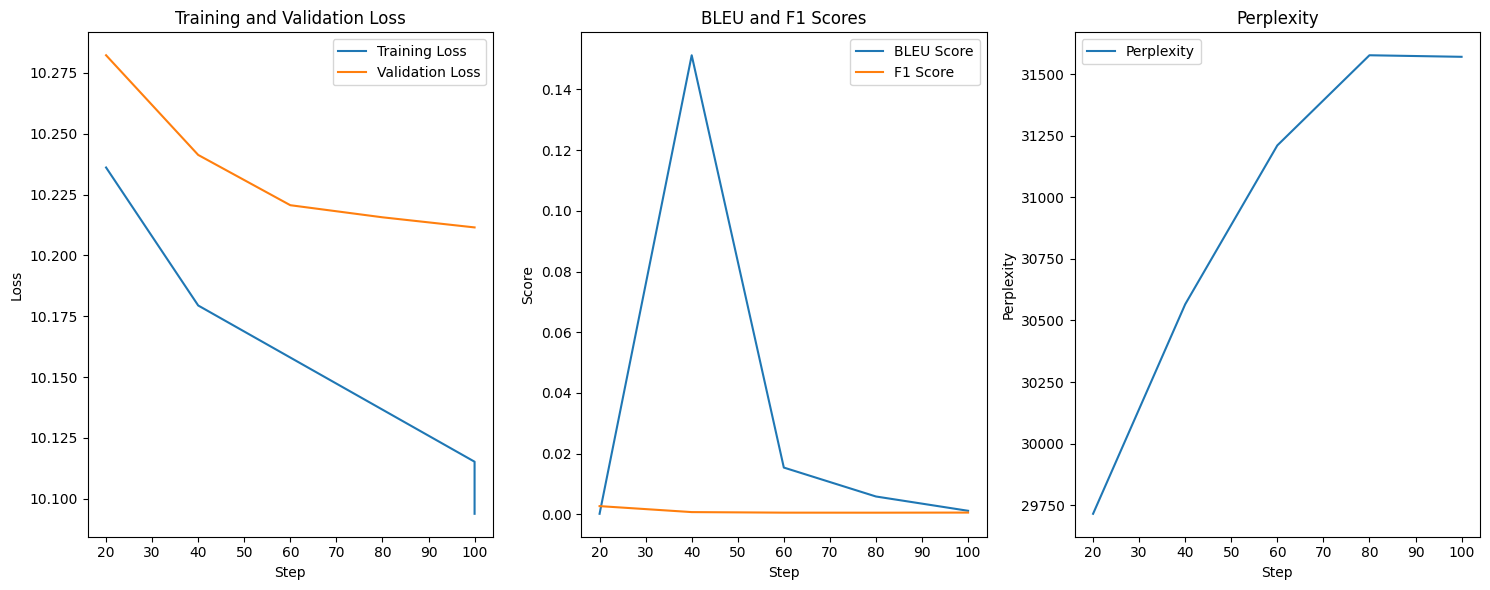



Gemini's analysis:


The model shows some concerning trends and doesn't seem to be learning effectively. Here's a breakdown:

* **Training Loss & Validation Loss:** Both training and validation loss are decreasing slightly, which is generally good.  However, the decrease is minimal, suggesting the model is learning very slowly or plateauing early. Also, the validation loss is consistently higher than the training loss, but not by a significant margin. This *could* indicate slight overfitting, but with such low performance overall, it's not the primary concern.

* **Bleu, F1, and Rougel:** These metrics, commonly used for text generation or sequence prediction tasks, are extremely low and fluctuate erratically.  This suggests the model is struggling to generate meaningful or accurate outputs. The instability is a red flag.

* **Perplexity:** Perplexity is increasing slightly alongside the decrease in losses. While a lower perplexity is generally better (indicating better predictive ab

In [33]:
# After training:
if agent.trainer is not None:  # Check if the trainer exists
    # 1. Create the table data
    data = []
    for i, log_entry in enumerate(agent.trainer.state.log_history):
        if "eval_loss" in log_entry:  # Check if it's an evaluation step
            # Get the actual step ID from the log entry:
            step_id = log_entry.get("step", "N/A")  # Assuming "step" is the key

            # Interpolate training loss if missing:
            if i < len(agent.train_losses):
                train_loss = agent.train_losses[i]
            else:
                # Interpolate using the last two available training losses
                if len(agent.train_losses) >= 2:
                    last_loss = agent.train_losses[-1]
                    second_last_loss = agent.train_losses[-2]
                    train_loss = last_loss + (last_loss - second_last_loss) * (i - len(agent.train_losses) + 1)
                else:
                    train_loss = "N/A"  # Handle cases where interpolation is not possible

            row = [
                step_id,  # Step number
                train_loss,  # Include training loss
                log_entry.get("eval_loss", "N/A"),  # Validation loss
                log_entry.get("eval_bleu", "N/A"),  # Bleu score
                log_entry.get("eval_f1", "N/A"),  # F1 score
                log_entry.get("eval_rougeL", "N/A"),  # Rougel score
                log_entry.get("eval_perplexity", "N/A"),  # Perplexity
            ]
            data.append(row)

    # 2. Define headers (include training loss)
    headers = ["step", "Training Loss", "Validation Loss", "Bleu", "F1", "Rougel", "Perplexity"]

    # 3. Create the table
    table = tabulate(data, headers=headers, tablefmt="grid")
    print('\n')
    print(table)

    # 4. Import matplotlib and create plots:
    import matplotlib.pyplot as plt

    steps = [row[0] for row in data]
    train_losses = [row[1] for row in data if row[1] != "N/A"]
    eval_losses = [row[2] for row in data if row[2] != "N/A"]
    bleu_scores = [row[3] for row in data if row[3] != "N/A"]
    f1_scores = [row[4] for row in data if row[4] != "N/A"]
    perplexities = [row[6] for row in data if row[6] != "N/A"]  # Extract perplexity values

    plt.figure(figsize=(15, 6))  # Increased figure size for 3 plots

    # Plot training and validation loss
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
    plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss")
    plt.plot(steps[:len(eval_losses)], eval_losses, label="Validation Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot BLEU and F1 scores
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    plt.plot(steps[:len(bleu_scores)], bleu_scores, label="BLEU Score")
    plt.plot(steps[:len(f1_scores)], f1_scores, label="F1 Score")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.title("BLEU and F1 Scores")
    plt.legend()

    # Plot Perplexity
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    plt.plot(steps[:len(perplexities)], perplexities, label="Perplexity")
    plt.xlabel("Step")
    plt.ylabel("Perplexity")
    plt.title("Perplexity")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # **5. LLM (Gemini) Analysis:**
    prompt = f"""
    Please analyze the following table containing evaluation metrics from a machine learning model:

    {table}

    I would like you to identify any trends or patterns in the metrics.
    For example, are the validation metrics improving or declining over time?
    Are there any signs of overfitting?
    """

    model_name = "gemini-1.5-pro"
    model = genai.GenerativeModel(model_name)  # Assuming you have the 'genai' library

    # Send the prompt to Gemini and get the response
    response = model.generate_content(prompt)
    llm_analysis = response.text

    # Print or process Gemini's analysis
    print('\n')
    print("Gemini's analysis:")
    print('\n')
    print(llm_analysis)

else:
    print("Trainer not available. Training might have failed.")

## LLM REPORT


In [15]:
import google.generativeai as genai
import numpy as np
from google.colab import userdata
import time
import json

# Used to securely store your API key
GOOGLE_API_KEY = userdata.get('GEMINI')  # Replace 'GEMINI' with your actual userdata variable name
genai.configure(api_key=GOOGLE_API_KEY)

from tabulate import tabulate
from transformers import TrainingArguments, TrainerState, TrainerControl

def generate_llm_report(
    rl_pairs,
    agents,
    training_args_list,
    state_list,
    control_list,
    output_file="experiment_report.txt",
    experiment_name=None,
    prompt="You are a helpful data science expert.\nPlease, make an additional analysis of this Fine-Tuning experiment report.",
):
    """
    Generates a report for multiple LLM experiments, including evaluation scores and training details,
    and provides an analysis using Google Gemini.

    Args:
        rl_pairs (list): A list of tuples, each containing (dataset_name, model_id, config).
        agents (list): A list of FineTuningAgent objects corresponding to the experiments.
        training_args_list (list): A list of TrainingArguments objects for each experiment.
        state_list (list): A list of TrainerState objects for each experiment.
        control_list (list): A list of TrainerControl objects for each experiment.
        output_file (str): The name of the output file to save the report.
        experiment_name (str, optional): The base name for the experiment results file.
                                        If provided, it will be used to load the results. Defaults to None.
        prompt (str, optional): The prompt to provide to Google Gemini for analysis.
                                Defaults to a generic data science expert prompt.
    """
    if not (
        len(rl_pairs)
        == len(agents)
        == len(training_args_list)
        == len(state_list)
        == len(control_list)
    ):
        raise ValueError(
            "The number of rl_pairs, agents, training_args, state, and control must be the same."
        )

    report_data = []

    for (
        (dataset_name, model_id, config),
        agent,
        training_args,
        state,
        control,
    ) in zip(rl_pairs, agents, training_args_list, state_list, control_list):

        print(f"Model ID: {model_id}")

        experiment_name = f"""{model_id.replace('/', '-').replace("'", '')}_{dataset_name.replace('/', '-').replace("'", '')}"""
        results_file = f"{experiment_name}_uftfresults.txt"
        print(f"Results File: {results_file}")

        from pathlib import Path
        file_path = Path(results_file)

        if not file_path.exists():
            print(f"Results file not found: {results_file}")
            continue  # Skip to the next experiment

        training_args = agent.training_args

        try:
            with open(results_file, "r") as f:
                evaluation_results = json.load(f)
            bleu_score = evaluation_results.get("eval_bleu")
            f1_score = evaluation_results.get("eval_f1")
            print(f"BLEU Score: {bleu_score}, F1 Score: {f1_score}")

            # Directly assign the 'eval_rougeL' value to rougeL_precision
            rougeL_precision = evaluation_results.get('eval_rougeL')
            rougeL_recall = None
            rougeL_fmeasure = None

            perplexity = evaluation_results.get("eval_perplexity", "N/A")

        except (FileNotFoundError, json.JSONDecodeError) as e:
            print(f"Error loading results: {e}")
            bleu_score = None
            f1_score = None
            rougeL_precision = None
            rougeL_recall = None
            rougeL_fmeasure = None
            perplexity = None

        # Collect the data
        elapsed_time = (
            agent.end_time - agent.start_time
            if agent.start_time and agent.end_time
            else np.nan
        )
        train_losses = agent.train_losses
        eval_losses = agent.eval_losses

        if not train_losses:
            train_loss = np.nan
            train_loss_std = np.nan
            min_train_loss = np.nan
            max_train_loss = np.nan
        else:
            train_loss = np.mean(train_losses)
            train_loss_std = np.std(train_losses)
            min_train_loss = np.min(train_losses)
            max_train_loss = np.max(train_losses)

        if not eval_losses:
            eval_loss = np.nan
            eval_loss_std = np.nan
            min_eval_loss = np.nan
            max_eval_loss = np.nan
        else:
            eval_loss = np.mean(eval_losses)
            eval_loss_std = np.std(eval_losses)
            min_eval_loss = np.min(eval_losses)
            max_eval_loss = np.max(eval_losses)

        learning_rate = training_args.learning_rate if training_args is not None else np.nan
        batch_size = training_args.per_device_train_batch_size if training_args is not None else np.nan
        epochs = training_args.num_train_epochs if training_args is not None and hasattr(training_args, "num_train_epochs") else "n/a"

        report_data.append(
            [
                dataset_name,
                model_id,
                f"{elapsed_time:.2f} seconds",
                f"{train_loss:.4f}" if not np.isnan(train_loss) else "N/A",
                f"{eval_loss:.4f}" if not np.isnan(eval_loss) else "N/A",
                f"{train_loss_std:.4f}" if not np.isnan(train_loss_std) else "N/A",
                f"{eval_loss_std:.4f}" if not np.isnan(eval_loss_std) else "N/A",
                f"{min_train_loss:.4f}" if not np.isnan(min_train_loss) else "N/A",
                f"{max_train_loss:.4f}" if not np.isnan(max_train_loss) else "N/A",
                f"{min_eval_loss:.4f}" if not np.isnan(min_eval_loss) else "N/A",
                f"{max_eval_loss:.4f}" if not np.isnan(max_eval_loss) else "N/A",
                f"{bleu_score:.4f}" if bleu_score is not None else "N/A",
                f"{f1_score:.4f}" if f1_score is not None else "N/A",
                f"{rougeL_precision:.4f}" if rougeL_precision is not None else "N/A",
                f"{perplexity:.4f}" if perplexity is not None else "N/A",  # Changed to perplexity
                f"{learning_rate:.4f}" if not np.isnan(learning_rate) else "N/A",
                f"{batch_size}" if not np.isnan(batch_size) else "N/A",
                f"{epochs}" if epochs is not None else "N/A",
            ]
        )

    # Generate the report table
    headers = [
        "Dataset",
        "Model",
        "Elapsed Time",
        "Avg Train Loss",
        "Avg Eval Loss",
        "Train Loss Std",
        "Eval Loss Std",
        "Min Train Loss",
        "Max Train Loss",
        "Min Eval Loss",
        "Max Eval Loss",
        "BLEU",
        "F1",
        "ROUGE-L",
        "Perplexity",
        "Learning Rate",
        "Batch Size",
        "Epochs",
    ]
    report_table = tabulate(report_data, headers=headers, tablefmt="grid")

    # Save the report to a file
    with open(output_file, "w") as f:
        f.write(report_table)
        f.write("\n\n")  # Add some spacing

    print(report_table)

    # LLM Analysis (commented out for now)
    """
    llm_analysis = get_llm_analysis(report_table, prompt)
    with open(output_file, "a") as f:
        f.write("## LLM Analysis\n")
        f.write(llm_analysis)
    print("\n## LLM Analysis\n")
    print(llm_analysis)
    """


    # LLM Analysis using Google Gemini
    model_name = "gemini-1.5-pro"  # Replace with desired model
    model = genai.GenerativeModel(model_name)
    response = model.generate_content(prompt + "\n\n" + report_table)
    llm_analysis = response.text

    print("\n\n## LLM Analysis:\n")
    print(llm_analysis)

    #return llm_analysis

In [16]:
# Generate the LLM report and send to Gemini
prompt = """
You are a helpful data science expert.
Please, make an additional analysis of this Fine-Tuning experiment report.
"""
# Initialize training_args_list, state_list, control_list with empty lists
training_args_list = [None] * len(rl_pairs)
state_list = [None] * len(rl_pairs)
control_list = [None] * len(rl_pairs)

generate_llm_report(rl_pairs, agents, training_args_list, state_list, control_list, prompt=prompt)

Model ID: mistralai/Mistral-7B-v0.1
Results File: mistralai-Mistral-7B-v0.1_sakharamg-AviationQA_uftfresults.txt
BLEU Score: 0.0011958836466728867, F1 Score: 0.0006071132063213468
+----------------------+---------------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+--------+--------+-----------+--------------+-----------------+--------------+----------+
| Dataset              | Model                     | Elapsed Time    |   Avg Train Loss |   Avg Eval Loss |   Train Loss Std |   Eval Loss Std |   Min Train Loss |   Max Train Loss |   Min Eval Loss |   Max Eval Loss |   BLEU |     F1 |   ROUGE-L |   Perplexity |   Learning Rate |   Batch Size |   Epochs |
+======================+===========================+=================+==================+=================+==================+=================+==================+==================+=================+====